In [1]:
import numpy as np
import pandas as pd
import copy
import math
import time
import random
import operator
import datetime
import csv
from dataclasses import dataclass, field

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Utils

In [2]:
def read_instance_data(instances_dir: str, file_path: str) -> (np.array, np.array, np.array):
    with open(instances_dir + file_path, 'r') as f:
        lines = f.readlines()
        n_machines, n_parts = map(int, lines[0].split())
        matrix = np.zeros(shape=(n_machines, n_parts), dtype=int)
        for line in lines[1:]:
            values = list(map(int, line.split()))
            m_id = values[0]
            for i in values[1:]:
                #substract 1 is required if ids of machines start from 1
                matrix[m_id-1][i-1] = 1
    m_ids, p_ids = list(range(1, n_machines+1)), list(range(1, n_parts+1))
    return matrix, m_ids, p_ids

In [3]:
def draw_matrix(matrix: np.array, m_ids: np.array=None, p_ids: np.array=None, title='') -> None:
    n_machines, n_parts = matrix.shape
    fig, ax = plt.subplots(figsize=(n_machines, 7))
    ax.matshow(matrix, cmap='gray_r')
    ax.set_xticks(range(n_parts))
    ax.set_yticks(range(n_machines))
    if p_ids is not None:
        ax.set_xticklabels(p_ids)
    if m_ids is not None:
        ax.set_yticklabels(m_ids)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [4]:
instances_dir = './resources/instances/'
instances = [f for f in listdir(instances_dir) 
             if isfile(join(instances_dir, f)) 
             and (f.endswith(".txt"))]

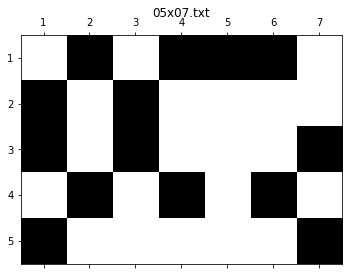

**************************************************


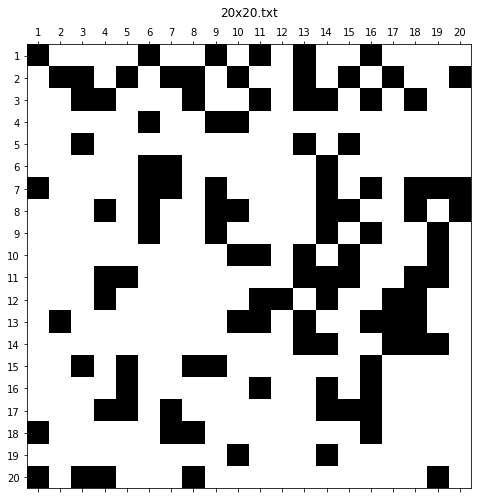

**************************************************


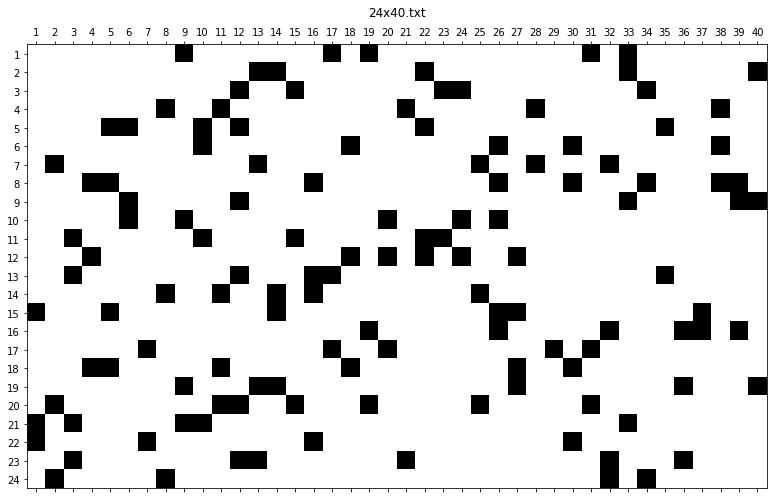

**************************************************


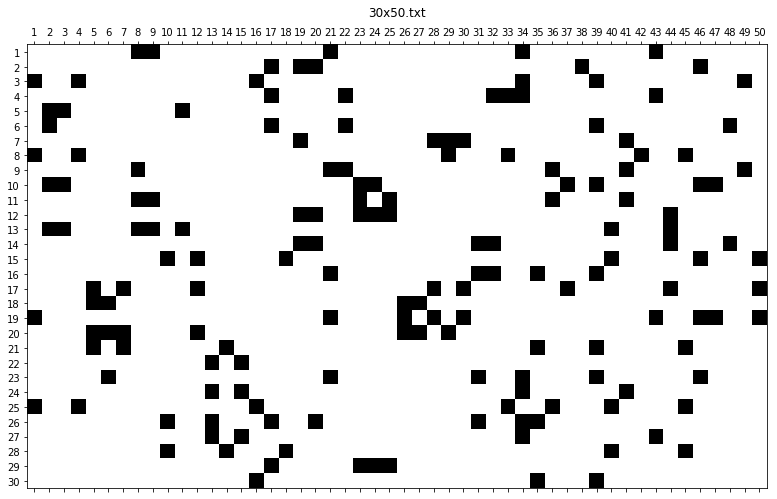

**************************************************


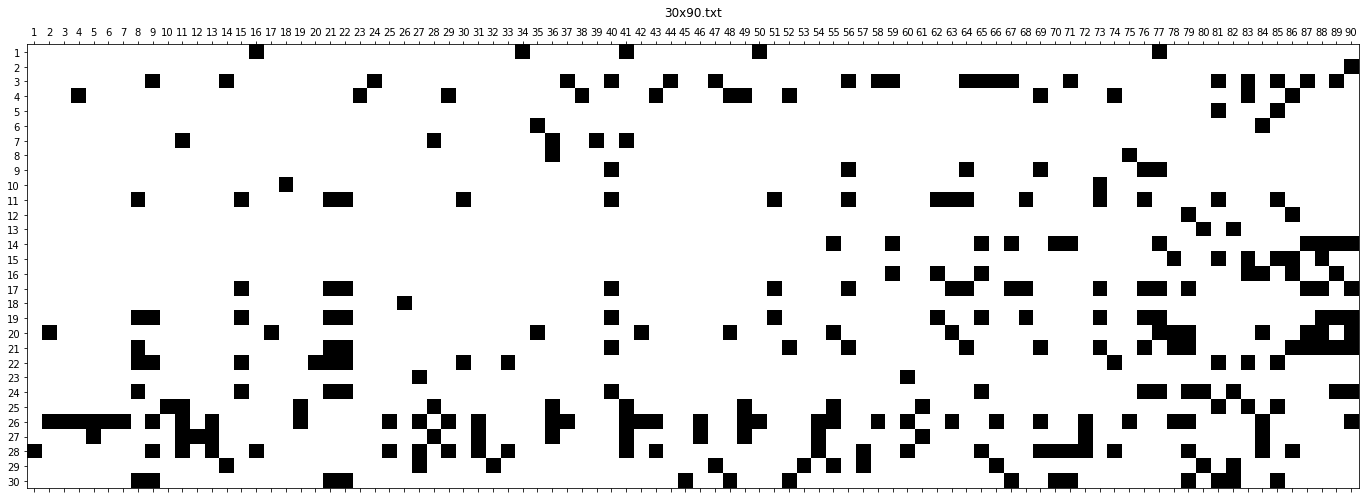

**************************************************


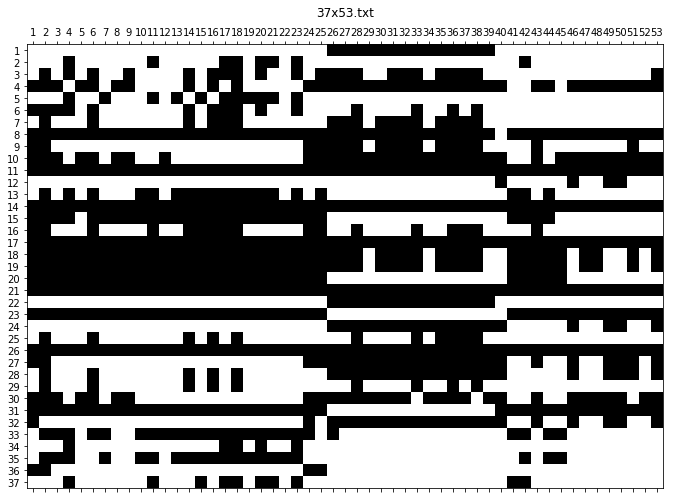

**************************************************


In [5]:
for instance in instances:
    matrix, m_ids, p_ids = read_instance_data(instances_dir, instance)
    draw_matrix(matrix, m_ids, p_ids, title=instance)
    print('*' * 50)

# Model

In [6]:
@dataclass
class Cluster():
    machines: list
    parts: list
    
    def __post_init__(self) -> None:
        self.n_machines = len(self.machines)
        self.n_parts = len(self.parts)
        
    def remove_machine(self, m_id: int) -> None:
        if m_id in self.machines:
            self.machines.remove(m_id)
            self.n_machines -= 1
    
    def add_machine(self, m_id: int) -> None:
        if m_id not in self.machines:
            self.machines.append(m_id)
            self.n_machines += 1
            
    def remove_part(self, p_id: int) -> None:
        if p_id in self.parts:
            self.parts.remove(p_id)
            self.n_parts -= 1
            
    def add_part(self, p_id: int) -> None:
        if p_id not in self.parts:
            self.parts.append(p_id)
            self.n_parts += 1

In [7]:
@dataclass
class Solution():
    clusters: list
    matrix: np.array = field(repr=False)
    ge: float = field(init=False)
    _n_ones_total: int = field(init=False, repr=False)
    
    def __post_init__(self):
        self._n_ones_total = (self.matrix == 1).sum()
        self.ge = self._obj_func()
        
    def __iter__(self):
        return iter(self.clusters)
    
    def __setitem__(self, index, value):
        self.clusters[index] = value
        self.ge = self._obj_func()
        
    def remove_cluster(self, cluster: Cluster) -> None:
        self.clusters.remove(cluster)
        self.ge = self._obj_func()
        
    def set_clusters(self, clusters: list) -> None:
        self.clusters = clusters
        self.ge = self._obj_func()
        
    def add_clusters(self, clusters: list) -> None:
        self.clusters.extend(clusters)
        self.ge = self._obj_func()
    
    def _obj_func(self) -> float:
        n_ones_in, n_zeros_in = 0, 0
        for cluster in self.clusters:
            for m_id in cluster.machines:
                for p_id in cluster.parts:
                    if self.matrix[m_id-1][p_id-1] == 1:
                        n_ones_in += 1
                    else:
                        n_zeros_in += 1
        return n_ones_in / (self._n_ones_total + n_zeros_in)
    
    def draw(self) -> None:
        result_m_ids = np.concatenate(list(map(lambda cl: cl.machines, self.clusters)))
        result_p_ids = np.concatenate(list(map(lambda cl: cl.parts, self.clusters)))
        m1 = self.matrix[[m_id-1 for m_id in result_m_ids], :]
        m2 = m1[:, [p_id-1 for p_id in result_p_ids]]
        draw_matrix(m2, result_m_ids, result_p_ids, title=f"GE={self.ge:.3f}")

# Neighborhood structures for Shaking:
- ### Split a random cluster into two
- ### Merge two random clusters into one

In [8]:
def split_cluster(cluster: Cluster) -> (Cluster, Cluster):
    split_m_idx = np.random.choice(range(1, len(cluster.machines)))
    split_p_idx = np.random.choice(range(1, len(cluster.parts)))
    first_cluster = Cluster(cluster.machines[:split_m_idx], cluster.parts[:split_p_idx])
    second_cluster = Cluster(cluster.machines[split_m_idx:], cluster.parts[split_p_idx:])
    return first_cluster, second_cluster

def one_random_split(sol: Solution) -> Solution:
    cluster_to_split = np.random.choice(sol.clusters)
    splitted_clusters = split_cluster(cluster_to_split)
    
    new_sol = copy.deepcopy(sol)
    new_sol.remove_cluster(cluster_to_split)
    new_sol.add_clusters(splitted_clusters)
    return new_sol

In [9]:
def merge_clusters(cluster_a: Cluster, cluster_b: Cluster) -> Cluster:
    return Cluster(cluster_a.machines + cluster_b.machines, 
                   cluster_a.parts + cluster_b.parts)

def one_random_merge(sol: Solution) -> Solution:
    clusters_to_merge = np.random.choice(sol.clusters, 2, replace=False)
    merged_cluster = merge_clusters(*clusters_to_merge)
    
    new_sol = copy.deepcopy(sol)
    for cl in clusters_to_merge:
        new_sol.remove_cluster(cl)
    new_sol.add_clusters([merged_cluster])
    return new_sol

# Neighborhood structures for VND:
- ### Move a machine from one cluster to another
- ### Move a part from one cluster to another

In [10]:
def move_machine(m_id: int, cluster_from: Cluster, cluster_to: Cluster) -> (Cluster, Cluster):
    new_a, new_b = copy.deepcopy(cluster_from), copy.deepcopy(cluster_to)
    new_a.remove_machine(m_id)
    new_b.add_machine(m_id)
    return new_a, new_b

def move_machines(sol: Solution) -> Solution:
#     print('MOVE MACHINES\nINIT:')
#     for cl in sol:
#         print(f"  {cl}")
#     print(f"  GE = {sol.ge: .3f}\n")
    
    best_sol, best_ge = sol, sol.ge
    for a in sol:
        for b in sol:
            if a != b and a.n_machines != 1:
                for m_id in a.machines:
#                     print(f"move machine {m_id} from {a.machines}  to {b.machines}")
                    new_a, new_b = move_machine(m_id, a, b)
                    current_sol = copy.deepcopy(sol)
                    current_sol[sol.clusters.index(a)] = new_a
                    current_sol[sol.clusters.index(b)] = new_b
#                     for cl in current_sol:
#                         print(cl)
                    current_ge = current_sol.ge
#                     print(f"GE = {current_ge: .3f}\n")
                    if current_ge > best_ge:
                        best_sol, best_ge = current_sol, current_ge
    
#     print(f"BEST SOLUTION:")
#     for cl in best_sol:
#         print(f"  {cl}")
#     print(f"  GE = {best_ge: .3f}")
#     print('*' * 50)
    return best_sol

In [11]:
def move_part(p_id:int, cluster_from: Cluster, cluster_to: Cluster) -> (Cluster, Cluster):
    new_a, new_b = copy.deepcopy(cluster_from), copy.deepcopy(cluster_to)
    new_a.remove_part(p_id)
    new_b.add_part(p_id)
    return new_a, new_b

def move_parts(sol: Solution) -> Solution:
#     print('MOVE PARTS\nINIT:')
#     for cl in sol:
#         print(f"  {cl}")
#     print(f"  GE = {sol.ge: .3f}\n")
    
    best_sol, best_ge = sol, sol.ge
    for a in sol:
        for b in sol:
            if a != b and a.n_parts != 1:
                for p_id in a.parts:
#                     print(f"move part {p_id} from {a.parts} to {b.parts}")
                    new_a, new_b = move_part(p_id, a, b)
                    current_sol = copy.deepcopy(sol)
                    current_sol[sol.clusters.index(a)] = new_a
                    current_sol[sol.clusters.index(b)] = new_b
#                     for cl in current_sol:
#                         print(cl)
                    current_ge = current_sol.ge
#                     print(f"GE = {current_ge: .3f}\n")
                    if current_ge > best_ge:
                        best_sol, best_ge = current_sol, current_ge
    
#     print(f"BEST SOLUTION:")
#     for cl in best_sol:
#         print(f"  {cl}")
#     print(f"  GE = {best_ge: .3f}")
#     print('*' * 50)
    return best_sol

# VND

In [12]:
def vnd(sol: Solution) -> Solution:
    best_sol, best_ge = sol, sol.ge
    
    operators = [move_machines, move_parts]
    l, l_max = 0, len(operators)
    iters = 1
    while l < l_max:
#         print(f"Iteration = {iters}")
        iters += 1
        current_sol = operators[l](best_sol)
        current_ge = current_sol.ge
        if current_ge > best_ge:
            best_sol, best_ge = current_sol, current_ge
            l = 0
        else:
            l += 1
        
    return best_sol

# General VNS

In [13]:
def vns(sol: Solution, max_iters: int=3) -> Solution:
    best_sol, best_ge = sol, sol.ge
    
    shaking_operators = [one_random_split, one_random_merge]
    k, k_max = 0, len(shaking_operators)
    iters = 1
    while k < k_max and iters <= max_iters:
        print(f"VNS Iteration = {iters}")
        iters += 1
        sh_sol = shaking_operators[k](best_sol)
        vnd_sol = vnd(sh_sol)
        vnd_ge = vnd_sol.ge
        if vnd_ge > best_ge:
            best_sol, best_ge = vnd_sol, vnd_ge
            print(f"New best solution:")
            for cl in best_sol:
                print(f"  {cl}")
            print(f"  GE = {best_ge: .3f}")
            print('*' * 50)
            k = 0
        else:
            k += 1
    
    return best_sol

# Test instances

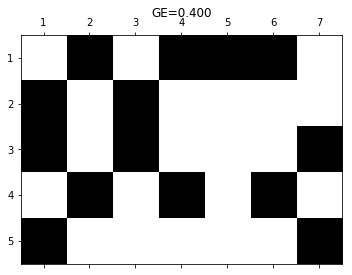

In [14]:
matrix, m_ids, p_ids = read_instance_data(instances_dir, '05x07.txt')
init_sol = Solution([Cluster(machines=m_ids, parts=p_ids)], matrix)
init_sol.draw()

In [15]:
some_sol = vns(init_sol, max_iters=5)

VNS Iteration = 1
New best solution:
  Cluster(machines=[1, 4], parts=[2, 4, 5, 6])
  Cluster(machines=[3, 5, 2], parts=[7, 1, 3])
  GE =  0.824
**************************************************
VNS Iteration = 2
VNS Iteration = 3


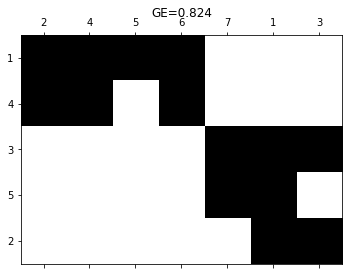

Cluster(machines=[1, 4], parts=[2, 4, 5, 6])
Cluster(machines=[3, 5, 2], parts=[7, 1, 3])


In [16]:
some_sol.draw()
for cl in some_sol:
    print(cl)

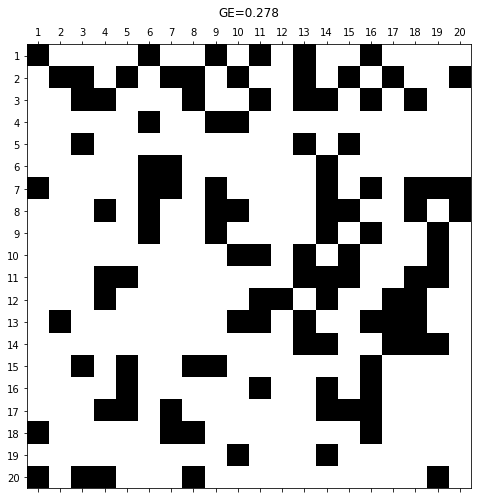

In [17]:
matrix, m_ids, p_ids = read_instance_data(instances_dir, '20x20.txt')
init_sol = Solution([Cluster(machines=m_ids, parts=p_ids)], matrix)
init_sol.draw()

In [18]:
some_sol = vns(init_sol, max_iters=10)

VNS Iteration = 1
New best solution:
  Cluster(machines=[1, 2, 4, 15, 20, 18, 13, 5, 6, 10], parts=[1, 2, 3, 6, 7, 8, 9, 10, 11, 13])
  Cluster(machines=[11, 12, 14, 16, 17, 19, 7, 9, 8, 3], parts=[14, 15, 16, 17, 18, 19, 20, 4, 5, 12])
  GE =  0.318
**************************************************
VNS Iteration = 2
New best solution:
  Cluster(machines=[2, 13, 10], parts=[2, 7, 10, 11, 13, 17, 20, 15, 12, 5])
  Cluster(machines=[11, 12, 14, 16, 17, 7, 9, 3, 8, 6, 4, 1], parts=[14, 16, 18, 19, 4, 6, 9])
  Cluster(machines=[5, 19, 20, 18, 15], parts=[3, 1, 8])
  GE =  0.387
**************************************************
VNS Iteration = 3
New best solution:
  Cluster(machines=[2, 13, 10], parts=[2, 7, 10, 11, 13, 17, 20, 15, 12, 5])
  Cluster(machines=[5, 20, 18, 15], parts=[3, 1, 8])
  Cluster(machines=[11, 12, 3, 14, 17, 16, 7, 19, 9, 8], parts=[14, 16, 18, 19, 4])
  Cluster(machines=[6, 4, 1], parts=[6, 9])
  GE =  0.403
**************************************************
VNS Ite

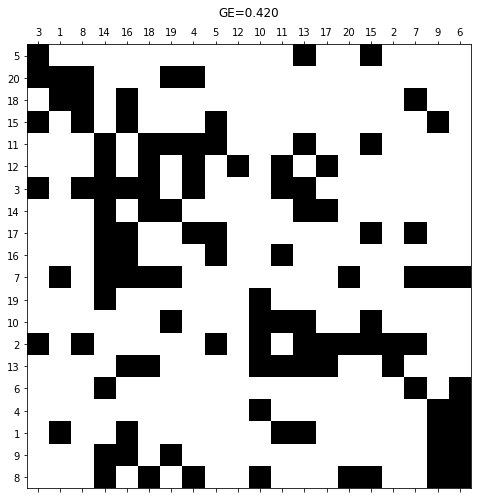

Cluster(machines=[5, 20, 18, 15], parts=[3, 1, 8])
Cluster(machines=[11, 12, 3, 14, 17, 16, 7], parts=[14, 16, 18, 19, 4, 5])
Cluster(machines=[19], parts=[12])
Cluster(machines=[10, 2, 13], parts=[10, 11, 13, 17, 20, 15, 2])
Cluster(machines=[6], parts=[7])
Cluster(machines=[4, 1, 9, 8], parts=[9, 6])


In [19]:
some_sol.draw()
for cl in some_sol:
    print(cl)